In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler

c:\Users\Zenrich\Documents\sheesh\ml\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [3]:
cols = ['flength', 'fwidth', 'fsize', 'fconc', 'fconcl', 'fasym', 'fmrlong', 'fm3trans', 'falpha', 'fdist', 'class']
df = pd.read_csv('magic04.data', names= cols) 

In [4]:
df['class'] = (df['class']== 'g').astype(int)

In [ ]:
for label in cols[:-1]:
    plt.hist(df[df['class'] == 1][label], color= 'blue', label='gamma', alpha= 0.7, density= True)
    plt.hist(df[df['class'] == 0][label], color= 'red', label='hadron', alpha= 0.7, density= True)
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

train, valid and test datasets

In [5]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])

c:\Users\Zenrich\Documents\sheesh\ml\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def scale_dataset(dataframe, oversample= False):
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()

    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x, y)
    
    data = np.hstack((x,np.reshape(y, (-1, 1))))
    return data, x, y

In [10]:
train, x_train, y_train = scale_dataset(train, oversample= True)
valid, x_valid, y_valid = scale_dataset(valid, oversample= False)
test, x_test, y_test = scale_dataset(test, oversample= False)

kNN

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)

KNeighborsClassifier()

In [20]:
y_pred = knn_model.predict(x_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73      1358
           1       0.87      0.80      0.84      2446

    accuracy                           0.80      3804
   macro avg       0.78      0.80      0.79      3804
weighted avg       0.81      0.80      0.80      3804



Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

In [27]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train, y_train)

In [28]:
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.40      0.50      1358
           1       0.73      0.90      0.81      2446

    accuracy                           0.72      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.72      0.70      3804



#Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(x_train, y_train)

In [32]:
y_pred = lg_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70      1358
           1       0.83      0.83      0.83      2446

    accuracy                           0.78      3804
   macro avg       0.76      0.76      0.76      3804
weighted avg       0.78      0.78      0.78      3804



Support Vector Machines

In [8]:
from sklearn.svm import SVC

In [11]:
svm_model = SVC()
svm_model = svm_model.fit(x_train, y_train)

In [12]:
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1322
           1       0.89      0.91      0.90      2482

    accuracy                           0.87      3804
   macro avg       0.86      0.85      0.85      3804
weighted avg       0.87      0.87      0.87      3804



Neural Network

In [10]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10, 4))
    ax1.plot(history.history['loss'], label= 'loss')
    ax1.plot(history.history['val_loss'], label= 'val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.grid(True)  

    ax2.plot(history.history['accuracy'], label= 'accuracy')
    ax2.plot(history.history['val_accuracy'], label= 'val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

In [11]:
def train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential(
    [    tf.keras.layers.Dense(num_nodes, activation= 'relu', input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(32, activation= 'relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation= 'sigmoid'),
    ])
    nn_model.compile(optimizer= tf.keras.optimizers.Adam(lr), loss= 'binary_crossentropy',
                    metrics= ['accuracy'])
    history = nn_model.fit(
    x_train, y_train, epochs= epochs, batch_size= batch_size, validation_split= 0.2, verbose=0
)
    return nn_model, history

In [12]:
epochs= 100
least_val_loss = float('inf')
least_loss_model = None
for num_nodes in [16,32,64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.1, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                
                model, history = train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
                val_loss = model.evaluate(x_valid, y_valid)
                val_loss = val_loss[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model
                    print(f"{num_nodes}:{dropout_prob}:{lr}:{batch_size}")
            

c:\Users\Zenrich\Documents\sheesh\ml\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.8470 - loss: 0.3825
16:0:0.1:32
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8552 - loss: 0.3569
16:0:0.1:64
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.8680 - loss: 0.3281
16:0:0.1:128
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.8594 - loss: 0.3452
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.8644 - loss: 0.3396
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8691 - loss: 0.3099
16:0:0.005:128
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.8638 - loss: 0.3101
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.8717 - loss: 0.3058
16:0:0.001:64
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.8683 - loss: 0.3088
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6356 - loss: 0.6564
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.8357 - loss: 0.4332
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.8438 - loss: 0.3823
119/119 ━━

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1376
           1       0.86      0.95      0.90      2428

    accuracy                           0.87      3804
   macro avg       0.88      0.84      0.85      3804
weighted avg       0.87      0.87      0.87      3804



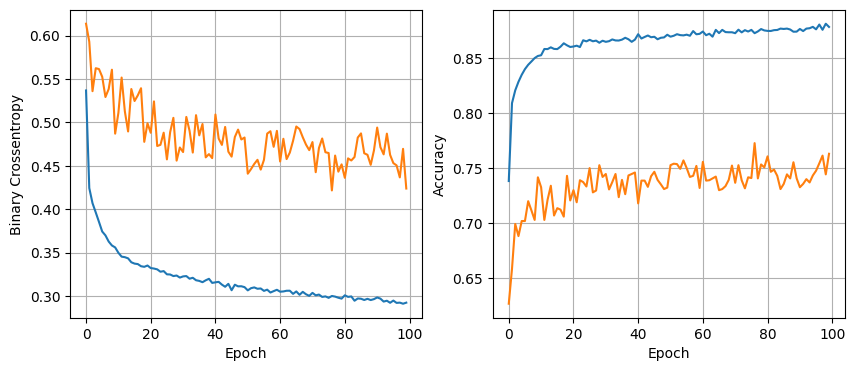

In [ ]:
y_pred = least_loss_model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_test, y_pred))


Linear Regression